In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
import numpy as np
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords

In [2]:
data = pd.read_csv('coursera_reviews.csv')
data = data.sample(frac=1, random_state=50)
data = data[:17000]
print(data)
tweet_df = data[['Review','Label']]
label = tweet_df['Label'].apply(lambda x: 0 if x < 4 else 1)
print(label.value_counts())
tweet = tweet_df['Review'].values
num_label = len(set(label))

            Id                                             Review  Label
30451    30451                        This course is very useful.      5
75777    75777  Excellent, clear, simple and brilliant! Simply...      5
16845    16845  it was interesting to learn about the dynamics...      5
28188    28188  I would like if there was some instructor feed...      4
106968  106968  It is perfect for beginners, but if you're an ...      3
...        ...                                                ...    ...
101005  101005  Fantastic course, with great videos and materi...      5
106566  106566  Enjoyed this learning and the peer review of c...      5
5680      5680  It was a good Mooc, but I think it should impl...      3
51109    51109          Great course. So much useful information.      5
65948    65948        Was very Interesting! I learned a lot!! Tks      4

[17000 rows x 3 columns]
1    15387
0     1613
Name: Label, dtype: int64


In [3]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder().fit_transform(label)
label = tf.keras.utils.to_categorical(label)

In [4]:
doc = []

from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

for sen in range(0, len(tweet)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(tweet[sen]))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization & remove Stopword
    document = document.split()
    
    swords = set(stopwords.words("english"))
    document = [w for w in document if w not in swords]

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    doc.append(document)

## Fungsi Word Embedding

In [5]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=500)
tokenizer.fit_on_texts(doc)

layer = tf.keras.layers.TextVectorization(max_tokens=200, output_sequence_length=50)
layer.adapt(doc, batch_size=64)
vt = layer(doc).numpy()
vt

array([[ 2, 17,  0, ...,  0,  0,  0],
       [ 9, 45, 96, ...,  0,  0,  0],
       [10, 12,  1, ...,  0,  0,  0],
       ...,
       [ 4,  1, 62, ...,  0,  0,  0],
       [ 3,  2, 14, ...,  0,  0,  0],
       [10, 31,  8, ...,  0,  0,  0]], dtype=int64)

In [58]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(vt, label, test_size=0.3, random_state=50) 
n_feature = X_train.shape[1] 
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape) 
print(n_feature)

(11900, 50) (11900, 2) (5100, 50) (5100, 2)
50


In [59]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('data/glove.twitter.27B.50d.txt', tokenizer.word_index, embedding_dim)

## check

In [60]:
vocab_size = len(tokenizer.word_index) + 1
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.8465885481592288

In [65]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=True, input_shape=(n_feature,)))
#model.add(Dropout(0.3))
#forward_layer = LSTM(64, return_sequences=True)
#backward_layer = LSTM(64, activation='relu', return_sequences=True, go_backwards=True)
#model.add(Bidirectional(forward_layer, backward_layer=backward_layer))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(num_label, activation='softmax'))

In [66]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 50, 50)            601650    
                                                                 
 bidirectional_20 (Bidirecti  (None, 50, 128)          58880     
 onal)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 50, 128)           0         
                                                                 
 bidirectional_21 (Bidirecti  (None, 256)              263168    
 onal)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_51 (Dense)            (None, 64)              

In [67]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss= tf.keras.losses.binary_crossentropy, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [68]:
#es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
372/372 [==============================] - 60s 146ms/step - loss: 0.2689 - accuracy: 0.9008 - precision_7: 0.9008 - recall_7: 0.9008 - val_loss: 0.2245 - val_accuracy: 0.9135 - val_precision_7: 0.9135 - val_recall_7: 0.9135
Epoch 2/20
372/372 [==============================] - 58s 156ms/step - loss: 0.2270 - accuracy: 0.9039 - precision_7: 0.9039 - recall_7: 0.9039 - val_loss: 0.2247 - val_accuracy: 0.9116 - val_precision_7: 0.9116 - val_recall_7: 0.9116
Epoch 3/20
372/372 [==============================] - 56s 150ms/step - loss: 0.2183 - accuracy: 0.9056 - precision_7: 0.9056 - recall_7: 0.9056 - val_loss: 0.2213 - val_accuracy: 0.9102 - val_precision_7: 0.9102 - val_recall_7: 0.9102
Epoch 4/20
372/372 [==============================] - 56s 150ms/step - loss: 0.2133 - accuracy: 0.9061 - precision_7: 0.9061 - recall_7: 0.9061 - val_loss: 0.2155 - val_accuracy: 0.9190 - val_precision_7: 0.9190 - val_recall_7: 0.9190
Epoch 5/20
372/372 [==============================] - 56s 15

In [69]:
loss, acc, prec, rec = model.evaluate(X_test, y_test, verbose=1)
f1 = 2*prec*rec/(prec+rec)
print('Loss: %.4f' % loss)
print('Accuracy: %.4f' % acc)
print('Precision: %.4f' % prec)
print('Recall: %.4f' % rec)
print('F1-Score: %.4f' % f1)

160/160 [==============================] - 4s 28ms/step - loss: 0.2255 - accuracy: 0.8986 - precision_7: 0.8986 - recall_7: 0.8986
Loss: 0.2255
Accuracy: 0.8986
Precision: 0.8986
Recall: 0.8986
F1-Score: 0.8986


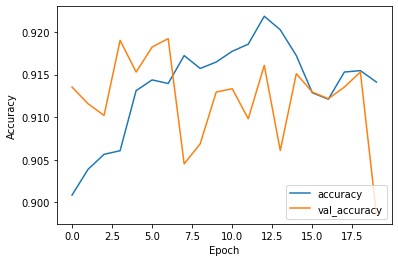

In [70]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim(0.6, 1.0)
plt.legend(loc='lower right')

In [71]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_encode2(x):
    vt = layer(x).numpy()
    padded_sequence = pad_sequences(vt, maxlen=n_feature, padding='post')
    return padded_sequence

In [76]:
x = ['This course is bad and teacher also bad and bored']
vec = get_encode2(x)
pred = model.predict(vec)
print(pred)
print("Bad" if np.argmax(pred) == 0 else "Good")

[[0.55610645 0.44389352]]
Bad


In [6]:
for i in range(1, 6):
    print(str(i)* i)

1
22
333
4444
55555
